In [96]:
import numpy as np, matplotlib.pyplot as plt, pulp, pandas as pd
from matplotlib import cm
from time import time
from tqdm.notebook import tqdm

In [97]:
np.random.seed(5)

In [98]:
# create functions
n = 100 # number of linear functions
d = 1
C = np.zeros(shape=(n,d))
C[0,:] = np.random.uniform(size=d)
C[1,:] = -np.random.uniform(size=d)
C[2:,:] = np.random.normal(size=(n-2,d))

b = np.random.normal(size=n)
x0 = np.random.normal(scale=2)

f = lambda x: np.max(C@np.array(x, ndmin=1) + b)
n_iters = 10000
df_err = pd.DataFrame(columns=('Sub-Grad', 'GRAAL', 'GRAAL (KL)')) # distance between current iterate and actual sol
df_time = pd.DataFrame(columns=('Sub-Grad', 'GRAAL', 'GRAAL (KL)')) # time at current iterate

In [100]:
# solve with LP first
prob = pulp.LpProblem('Linear', pulp.LpMinimize)

# variables
t = pulp.LpVariable('Auxiliary', lowBound=0)
x = pulp.LpVariable('x axis')

# objective
prob += t

# constraints
for i in range(n):
    prob += t >= C[i]*x  + b[i]

prob.solve()

1

In [101]:
sol = x.varValue
obj = prob.objective.value()
sol

0.11549439

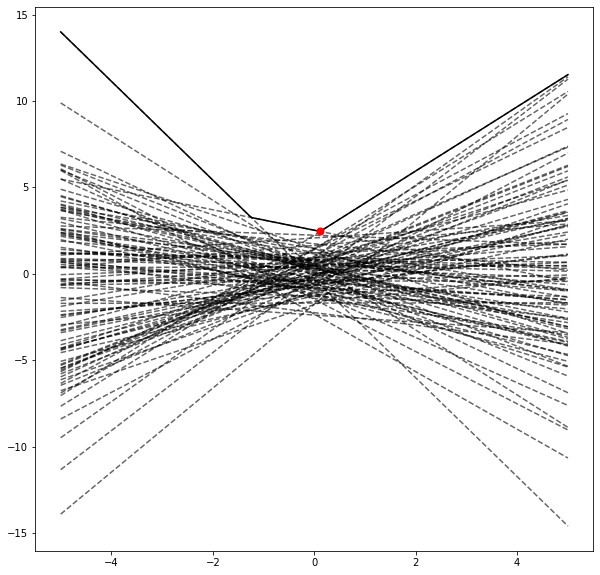

In [102]:
fig = plt.figure(figsize=(10,10))
X = np.linspace(-5,5,250)

for i in tqdm(range(n)):
    fi_v = np.vectorize(lambda x: C[i]*x + b[i])
    Y = fi_v(X)
    plt.plot(X,Y,'k--', alpha=.6)

f_v = np.vectorize(f)
Y = f_v(X)
plt.plot(X, Y, 'k-')
plt.plot(sol, f(sol), 'r.', markersize=14)
plt.show()

In [103]:
# sub gradient

x = x0
time0 = time()
gamma = lambda k: 1/(10+k)
fi = lambda x,i: C[i]*x + b[i]

for k in tqdm(range(n_iters)):
    gamma = 1/(10+k)
    fval = f(x)
    G = np.array([C[i] for i in range(n) if np.isclose(fi(x, i), fval)])
    g = G.mean()
    
    if g == 0: # solution reached
        df_err.loc[k:, 'Sub-Grad'] = 0
        df_time.loc[k:, 'Sub-Grad'] = time()-time0
        break
        
    x, x1 = x - gamma*g/np.linalg.norm(g), x
    err = np.linalg.norm(fval - f(x))
    df_err.loc[k, 'Sub-Grad'] = np.linalg.norm(f(x)-obj) 
    df_time.loc[k, 'Sub-Grad'] = time()-time0

In [104]:
# GRAAL 

x = x0
y = np.ones(shape=n)/n
z = np.array([x, *y])
x_ = x + np.random.uniform()
z_ = np.array([x_, *y])
time0 = time()
phi = (1 + np.sqrt(5))/2

F = lambda z: np.array([*(z[-n:]@C), *(-C@z[:-n]-b)])

L = np.linalg.norm(C)
lam = phi/(2*L)
k = 0

def sim_proj(z, la=None):
    # projection of y component onto simplex. scalar and x var ignored
    x, y = z[:-n], z[-n:]
    u = sorted(y, reverse=True)
    rho = max(
        j for j in range(n)
        if u[j] + (1/(j+1))*(1 - sum(u[:j+1])) > 0
    )
    la = (1/(rho+1))*(1 - sum(u[:rho+1]))
    
    for i in range(n): y[i] = max(y[i] + la, 0)
    
    return np.array([*x, *y])

for k in tqdm(range(n_iters)):
    z_ = ((phi-1)*z + z_)/phi
    z = sim_proj(z_ - lam*F(z))
    x = z[0]
#     err = np.linalg.norm(f(x) - f(x1))
    df_err.loc[k, 'GRAAL'] = np.linalg.norm(f(x)-obj) 
    df_time.loc[k, 'GRAAL'] = time()-time0

In [105]:
# GRAAL (KL)

x = x0
y = np.ones(shape=n)/n
z = np.array([x, *y])
x_ = x + np.random.uniform()
z_ = np.array([x_, *y])
time0 = time()
phi = (1 + np.sqrt(5))/2

F = lambda z: np.array([*(z[-n:]@C), *(-C@z[:-n]-b)])
h = lambda y: np.sum([y[i]*np.log(y[i]) for i in np.where(y!=0)])
g_h = lambda y: np.log(y) + 1
g_h_inv = lambda y: np.exp(y-1)    

L = np.linalg.norm(C)
lam = phi/(2*L)
k = 0

def step(z, z_, F, la):
    # complete step of algorithm
    x, y = z[:-n], z[-n:]
    x_, y_ = z_[:-n], z_[-n:]
    Fx, Fy = F[:-n], F[-n:]
    
    x_ = ((phi-1)*x + x_)/phi
    x = x_ - la*Fx
    
    y_ = g_h_inv(((phi-1)*g_h(y) + g_h(y_))/phi)
    u = g_h_inv(g_h(y_) - la*Fy) # intermediate projection step
    y = u/np.linalg.norm(u, ord=1)
    
    z = np.array([*x, *y])
    z_ = np.array([*x_, *y_])
    return z, z_

for k in tqdm(range(n_iters)):
    z, z_ = step(z, z_, F(z), lam)
    x = z[0]
    df_err.loc[k, 'GRAAL (KL)'] = f(x)-obj 
    df_time.loc[k, 'GRAAL (KL)'] = time()-time0

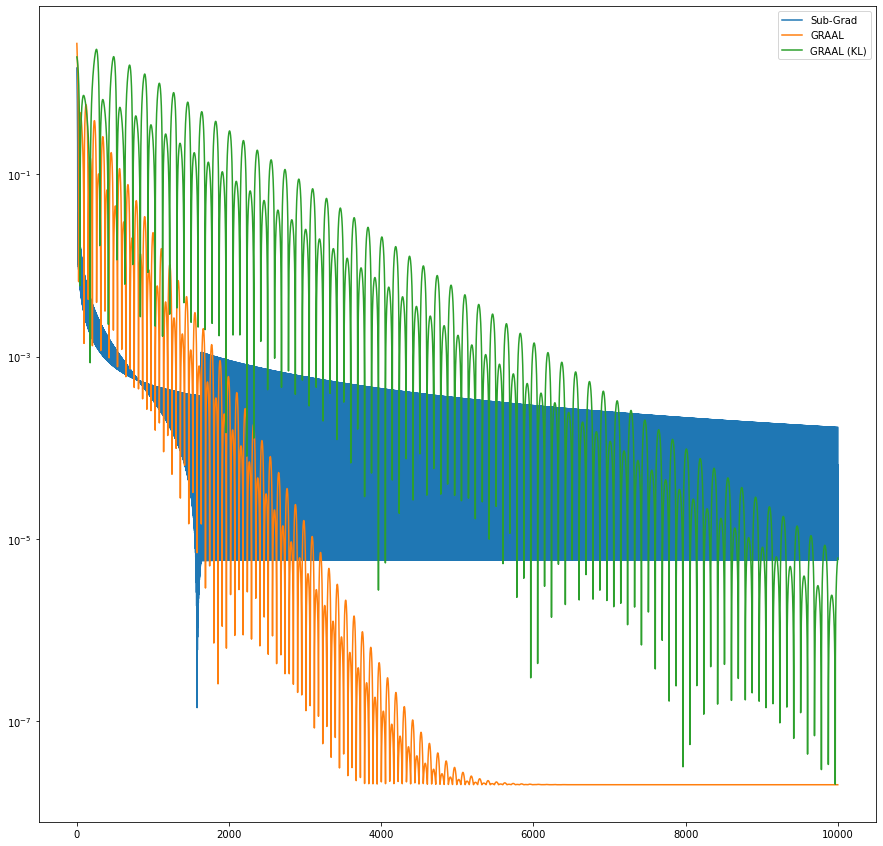

In [106]:
fig, ax = plt.subplots(figsize=(15,15))
df_err.plot(ax=ax, logy=True)
plt.show()

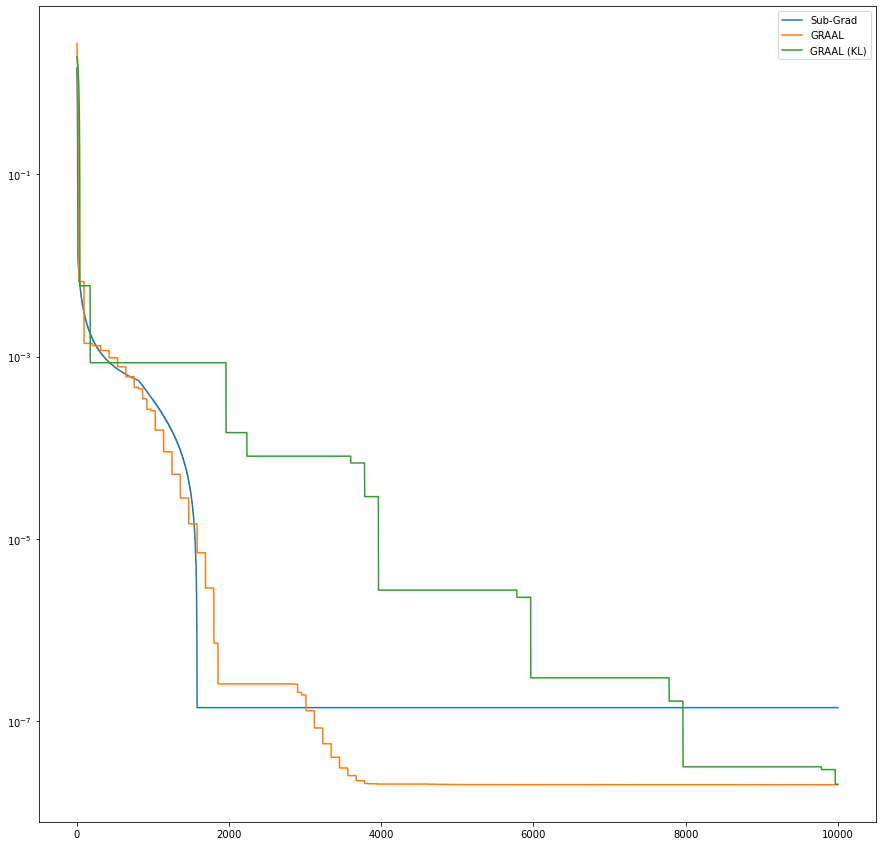

In [107]:
df_min_err = df_err.apply(lambda col: [min(col.loc[:i]) for i in range(n_iters)])

fig, ax = plt.subplots(figsize=(15,15))
df_min_err.plot(ax=ax,logy=True)
#fig.savefig('err.png')
plt.show()

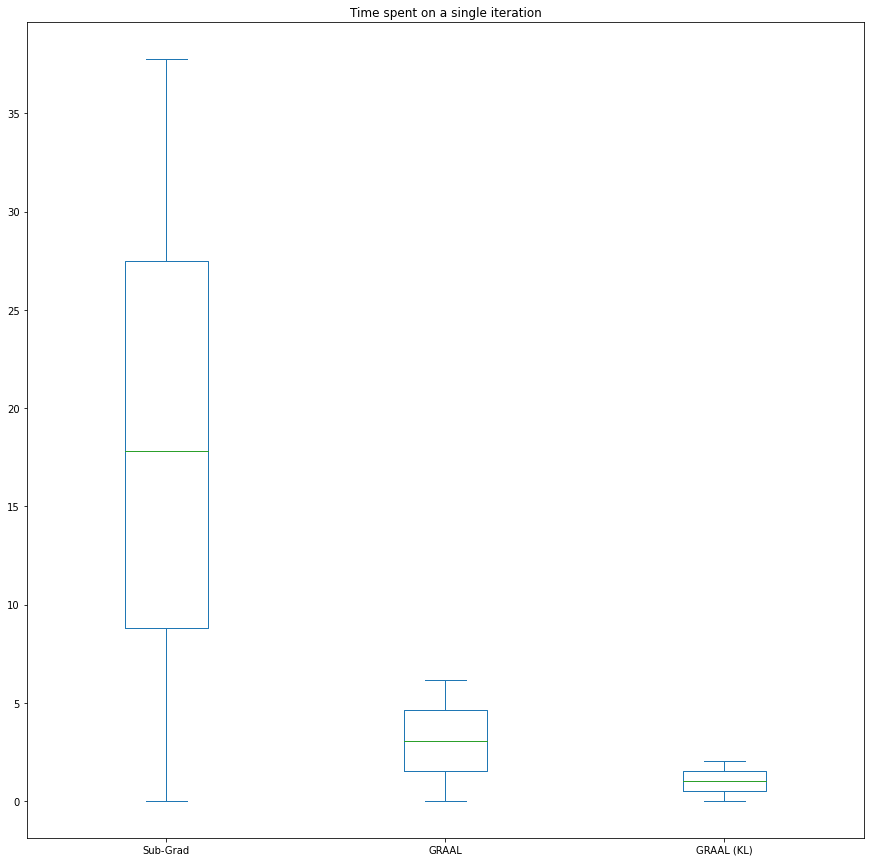

In [126]:
df_time.plot.box(figsize=(15,15), title='Time spent on a single iteration')
plt.show()